In [18]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [19]:
cd D:\Deep learning

D:\Deep learning


In [20]:
train = pd.read_csv("twitter_train.csv", encoding='latin-1')
test = pd.read_csv("twitter_test.csv", encoding='latin-1')

In [21]:
train.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


# Removing Twitter Handles (@user)

In [22]:
#Data Cleaning
combi = train.append(test, ignore_index=True)

C:\Users\USER\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [23]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

In [25]:
# remove twitter handles (@user)

#Now let’s create a new column tidy_tweet, it will contain the cleaned and processed tweets.
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['SentimentText'], "@[\w]*")

# Removing Punctuations, Numbers, and Special Characters

In [26]:
# remove special characters, numbers, punctuations
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

#  Removing Short Words

In [27]:
#We have to be a little careful here in selecting the length of the words which we want to remove. So, I have decided to remove all the words having length 3 or less.
combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [28]:
combi.head()

,ItemID,Sentiment,SentimentText,tidy_tweet
0,1,0.0,is so sad for my APL frie...,friend
1,2,0.0,I missed the New Moon trail...,missed Moon trailer
2,3,1.0,omg its already 7:30 :O,already
3,4,0.0,.. Omgaga. Im sooo im gunna CRy. I'...,Omgaga sooo gunna been this dentist since supo...
4,5,0.0,i think mi bf is cheating on me!!! ...,think cheating


# Tokenization

In [29]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0                                             [friend]
1                              [missed, Moon, trailer]
2                                            [already]
3    [Omgaga, sooo, gunna, been, this, dentist, sin...
4                                    [think, cheating]
Name: tidy_tweet, dtype: object

# Stemming

In [30]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0                                             [friend]
1                                [miss, moon, trailer]
2                                            [alreadi]
3    [omgaga, sooo, gunna, been, thi, dentist, sinc...
4                                       [think, cheat]
Name: tidy_tweet, dtype: object

In [31]:
#Now let’s stitch these tokens back together.
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combi['tidy_tweet'] = tokenized_tweet

# Understanding the common words used in the tweets: WordCloud

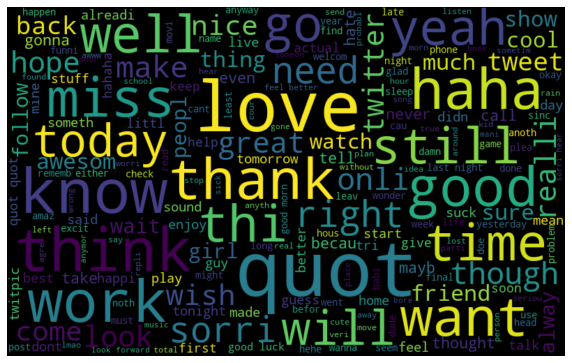

In [33]:
all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# wordclouds for both the classes(racist/sexist or not) in our train data.

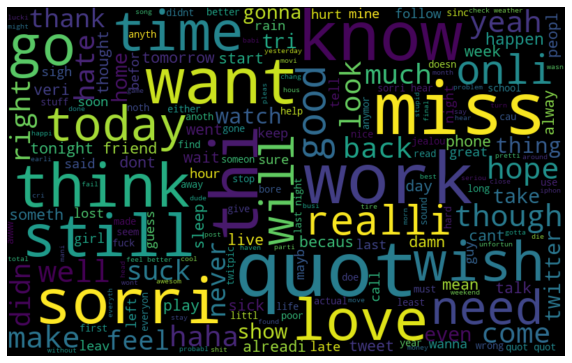

In [35]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['Sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Understanding the impact of Hashtags on tweets sentiment

In [36]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [38]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['Sentiment'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['Sentiment'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

# Non-Racist/Sexist Tweets

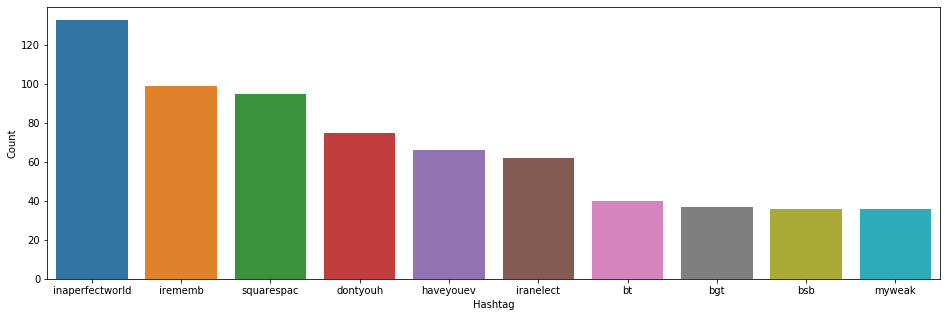

In [39]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

# Racist/Sexist Tweets

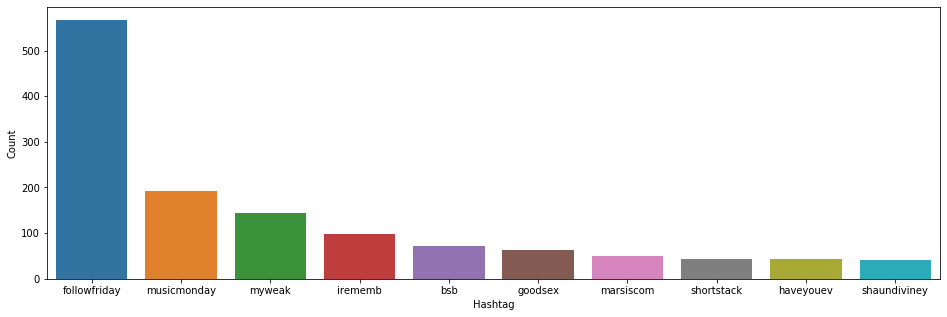

In [40]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

# Bag-of-Words Features

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

# TF-IDF Features

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

# Building model using Bag-of-Words features

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:99989,:]
test_bow = bow[299989:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['Sentiment'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.7644435874569162

# Building model using TF-IDF features

In [56]:
train_tfidf = tfidf[:99989,:]
test_tfidf = tfidf[299989:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.7644568459540075